In [128]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

In [129]:
df = pd.read_csv(f'{path}2024-12-16T16:36:07.035Z_results-csr-sd.csv', sep=',')
df_t = pd.read_csv(f'{path}2024-12-16T18:34:29.952Z_results-csr-sd-throttled.csv', sep=',')
df_ht = pd.read_csv(f'{path}2024-12-16T21:24:01.210Z_results-csr-sd-throttled-heavy.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']

dirty_dfs = {
    'default': df[5:],
    'throttled': df_t[5:],
    'heavy': df_ht[5:],
}

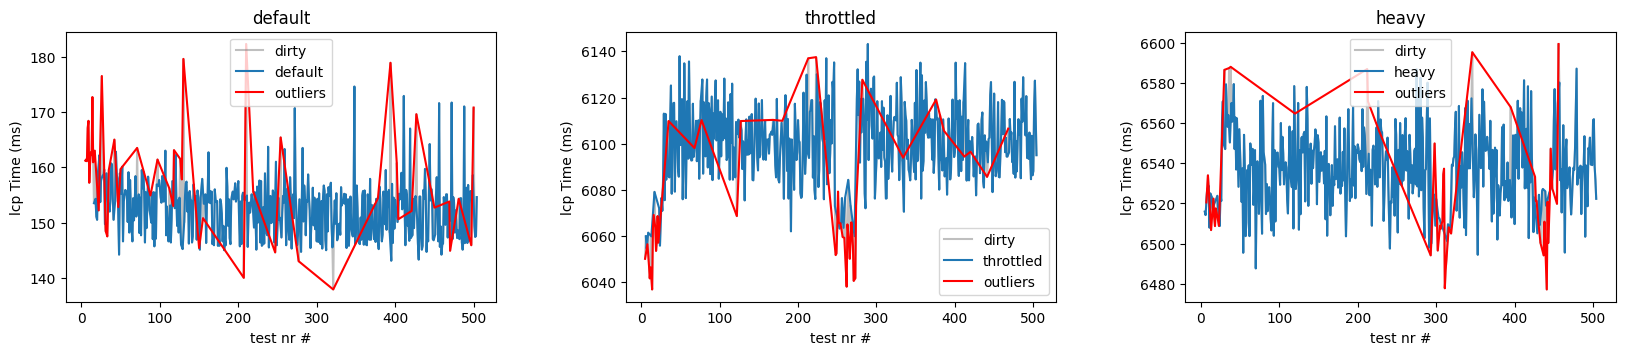

In [130]:
def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1

def plot_outliers(_df, d, loc, mask):
    loc.plot(_df['lcp'], label='dirty', color='gray', alpha=0.5)
    loc.plot(_df['lcp'][mask[d]], label=d)
    loc.plot(_df['lcp'][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'lcp Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.legend()

masks = {}
dfs = {}
target_features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb']

for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

graph_row(lambda _ds, loc, idx: plot_outliers(_ds, list(dfs.keys())[idx], loc, masks), dirty_dfs)
plt.show()

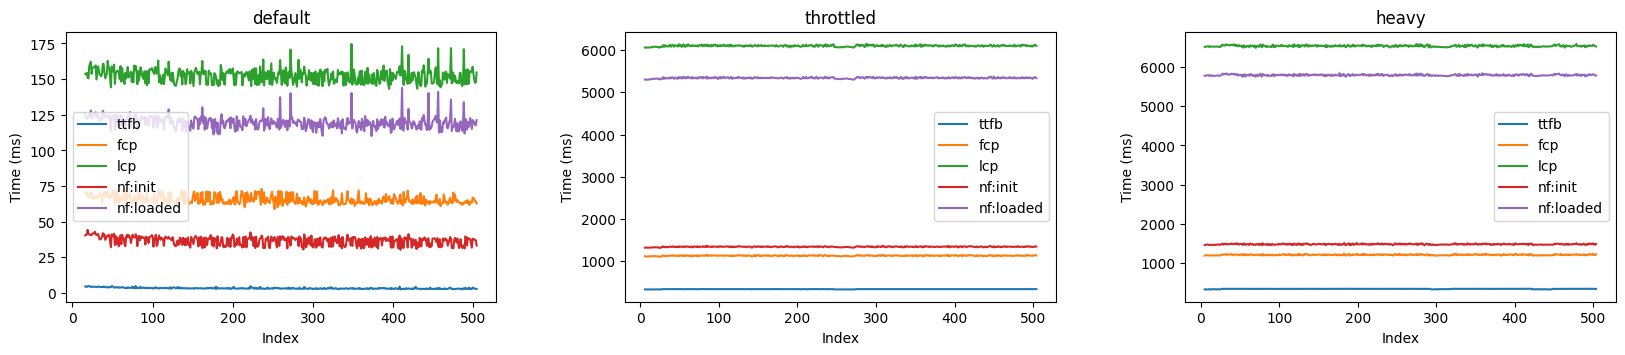

In [131]:
def plot_line(dataset, loc, idx):
    for t in ['ttfb', 'fcp', 'lcp', 'nf:init', 'nf:loaded']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

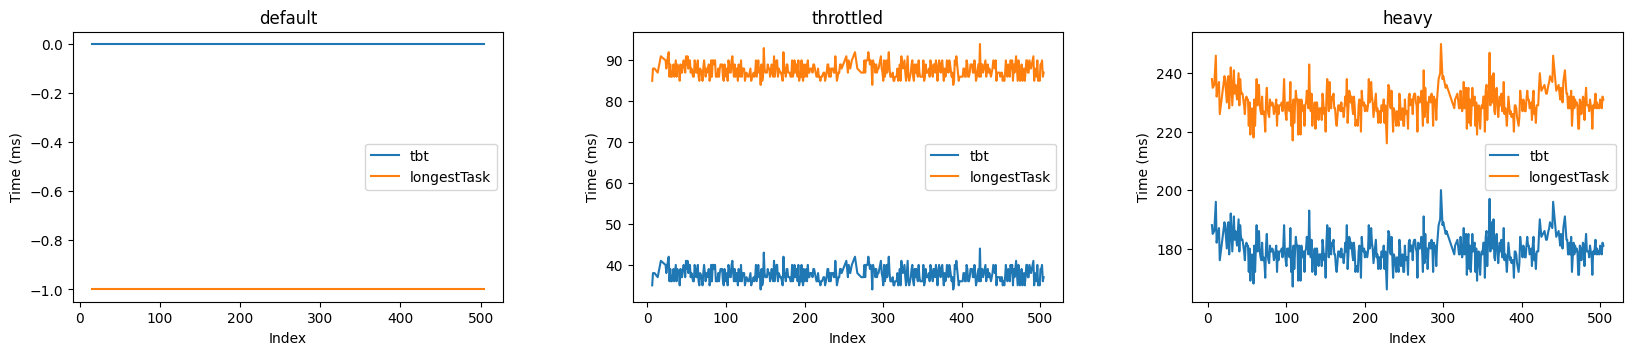

In [132]:
def plot_line(dataset, loc, idx):
    for t in ['tbt', 'longestTask']:
        loc.plot(dataset[t], label=t)
    loc.set_xlabel('Index')
    loc.set_ylabel('Time (ms)')
    loc.legend()

graph_row(plot_line, dfs)
plt.show()

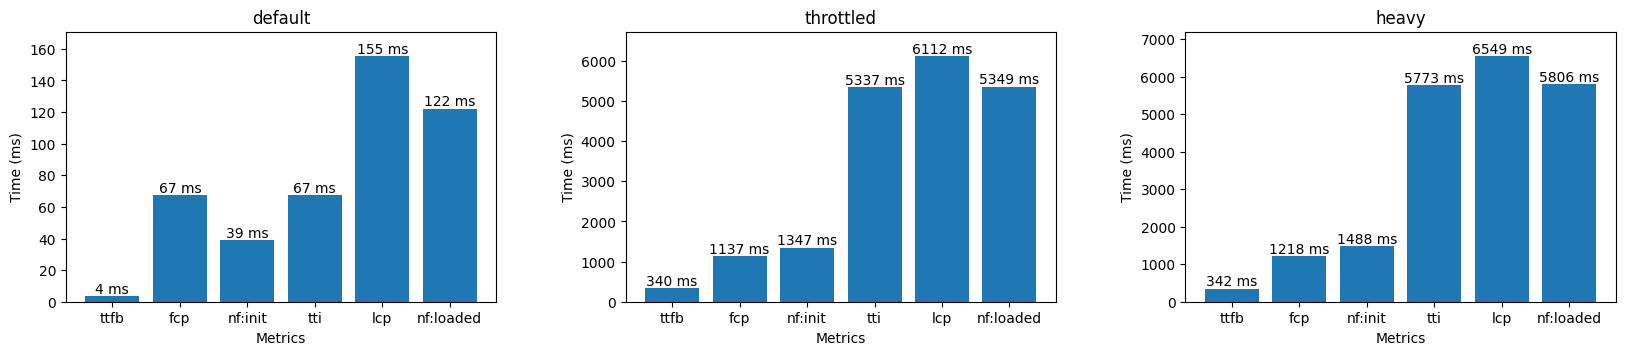

In [133]:
def plot_timeline_bars(dataset, loc, idx):
    metrics = ['ttfb', 'fcp', 'nf:init', 'tti', 'lcp', 'nf:loaded']
    quantiles = [dataset[t].quantile(0.75) for t in metrics]
    bars = loc.bar(metrics, quantiles, label='75th percentile')
    loc.set_xlabel('Metrics')
    loc.set_ylabel('Time (ms)')
    
    for bar in bars:
        height = bar.get_height()
        loc.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f} ms', ha='center', va='bottom')
    
    loc.set_ylim(0, max(quantiles) * 1.1)

graph_row(plot_timeline_bars, dfs)
plt.show()

In [134]:
dfs['default'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,264.37,8.04,62.93,152.46,65.48,3.32,0.00,65.48,0.00,-1.00,36.62,41.83,119.64,NaN
std,138.58,0.73,5.45,5.03,3.08,0.45,0.00,3.08,0.00,0.00,3.04,3.52,4.45,NaN
min,17.00,7.00,54.00,143.10,58.70,2.50,0.00,58.70,0.00,-1.00,30.30,35.10,110.10,NaN
25%,147.25,8.00,58.25,147.80,63.10,3.00,0.00,63.10,0.00,-1.00,33.40,38.00,116.30,NaN
50%,266.50,8.00,61.00,153.60,64.50,3.20,0.00,64.50,0.00,-1.00,37.70,42.80,119.80,NaN
75%,381.75,8.00,68.00,155.30,67.30,3.50,0.00,67.30,0.00,-1.00,38.90,44.58,122.07,NaN
max,505.00,10.00,79.00,174.60,73.00,4.90,0.00,73.00,0.00,-1.00,44.30,60.00,143.80,NaN


In [135]:
dfs['throttled'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,262.64,335.39,5345.60,6101.09,1132.41,339.76,37.65,5327.96,1.00,87.65,1343.14,1726.60,5340.56,NaN
std,143.57,2.22,13.46,15.87,7.91,1.72,1.78,13.39,0.00,1.78,7.92,10.00,13.44,NaN
min,7.00,326.00,5303.00,6054.50,1105.90,332.30,34.00,5285.40,1.00,84.00,1315.10,1687.10,5297.20,NaN
25%,137.25,335.00,5337.00,6091.93,1127.63,339.80,36.00,5319.23,1.00,86.00,1338.20,1722.00,5331.45,NaN
50%,263.00,336.00,5345.00,6101.75,1134.75,340.00,37.00,5327.20,1.00,87.00,1344.80,1729.50,5339.55,NaN
75%,388.75,337.00,5355.00,6111.50,1136.60,340.30,39.00,5337.00,1.00,89.00,1346.70,1732.00,5349.38,NaN
max,505.00,339.00,5379.00,6143.20,1152.80,344.10,44.00,5361.30,1.00,94.00,1366.90,1751.70,5373.40,NaN


In [136]:
dfs['heavy'].describe()

,idx,navTime,totalTime,lcp,fcp,ttfb,tbt,tti,longTasks,longestTask,nf:init,nf:config,nf:loaded,error
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,450.00,0.00
mean,253.61,344.29,5806.48,6537.69,1210.71,341.02,179.59,5761.44,2.00,229.59,1479.91,1870.17,5795.11,NaN
std,142.70,3.63,17.07,18.68,10.68,3.35,4.87,16.60,0.00,4.87,11.41,13.28,16.94,NaN
min,6.00,330.00,5759.00,6487.60,1186.90,326.60,166.00,5713.30,2.00,216.00,1450.90,1840.50,5749.70,NaN
25%,131.25,344.00,5795.00,6525.10,1203.70,341.10,177.00,5749.63,2.00,227.00,1473.33,1863.02,5783.32,NaN
50%,246.50,345.00,5806.00,6537.60,1211.15,341.60,179.00,5761.15,2.00,229.00,1480.70,1871.70,5794.60,NaN
75%,376.75,346.00,5818.00,6548.72,1217.95,342.50,182.00,5773.20,2.00,232.00,1488.40,1879.18,5806.50,NaN
max,505.00,348.00,5851.00,6587.20,1240.90,344.40,200.00,5804.20,2.00,250.00,1511.50,1905.00,5842.30,NaN


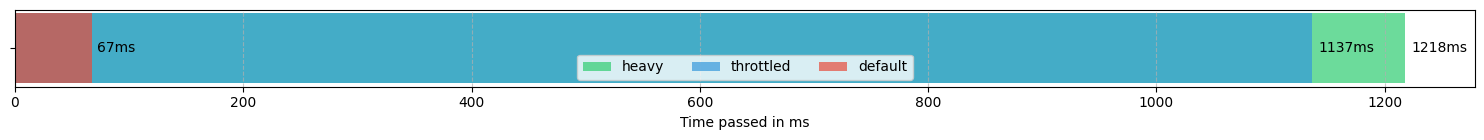

In [137]:
fig, ax = plt.subplots(figsize=(15, 1.5))

fcp_values = [df['fcp'].quantile(0.75) for df in dfs.values()]

bar_height = 0.25
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = []
for i, (name, value) in enumerate(zip(reversed(dfs.keys()), reversed(fcp_values))):
    bar = ax.barh(0.5, value, height=bar_height, 
                 label=name, color=colors[i], alpha=0.7)
    bars.append(bar)

ax.set_yticks([0.5])
ax.set_yticklabels([''])
ax.set_xlabel('Time passed in ms')

ax.grid(True, axis='x', linestyle='--', alpha=0.7)

for i, bar in enumerate(bars):
    width = bar[0].get_width()
    ax.text(width + 5, bar[0].get_y() + bar[0].get_height()/2, 
            f'{fcp_values[-(i+1)]:.0f}ms', 
            va='center')

ax.legend(loc='lower center', ncols=3)

plt.tight_layout()

plt.show()

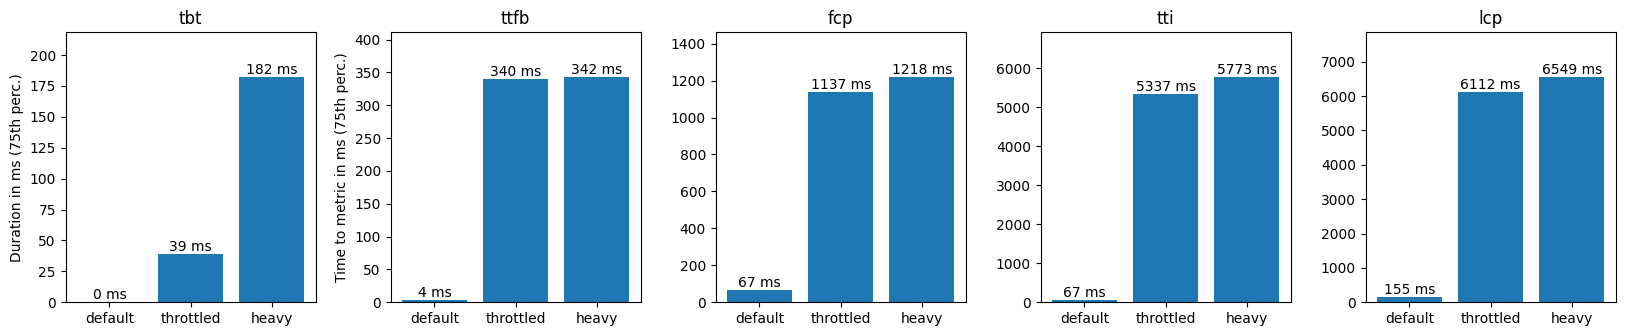

In [138]:
features = ['tbt','ttfb', 'fcp', 'tti', 'lcp']
fig, axes = plt.subplots(ncols=len(features), figsize=(20, 3))
plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)

for idx, feature in enumerate(features):
    percentiles = {d: dfs[d][feature].quantile(0.75) for d in dfs.keys()}
    bars = axes[idx].bar(percentiles.keys(), percentiles.values())
    
    max_height = max(percentiles.values())
    axes[idx].set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        label = f'{int(round(height, 0))} ms'
        axes[idx].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
    
    axes[idx].set_title(feature)
    if idx == 0:
        axes[idx].set_ylabel('Duration in ms (75th perc.)')
    if idx == 1:
        axes[idx].set_ylabel('Time to metric in ms (75th perc.)')

plt.show()

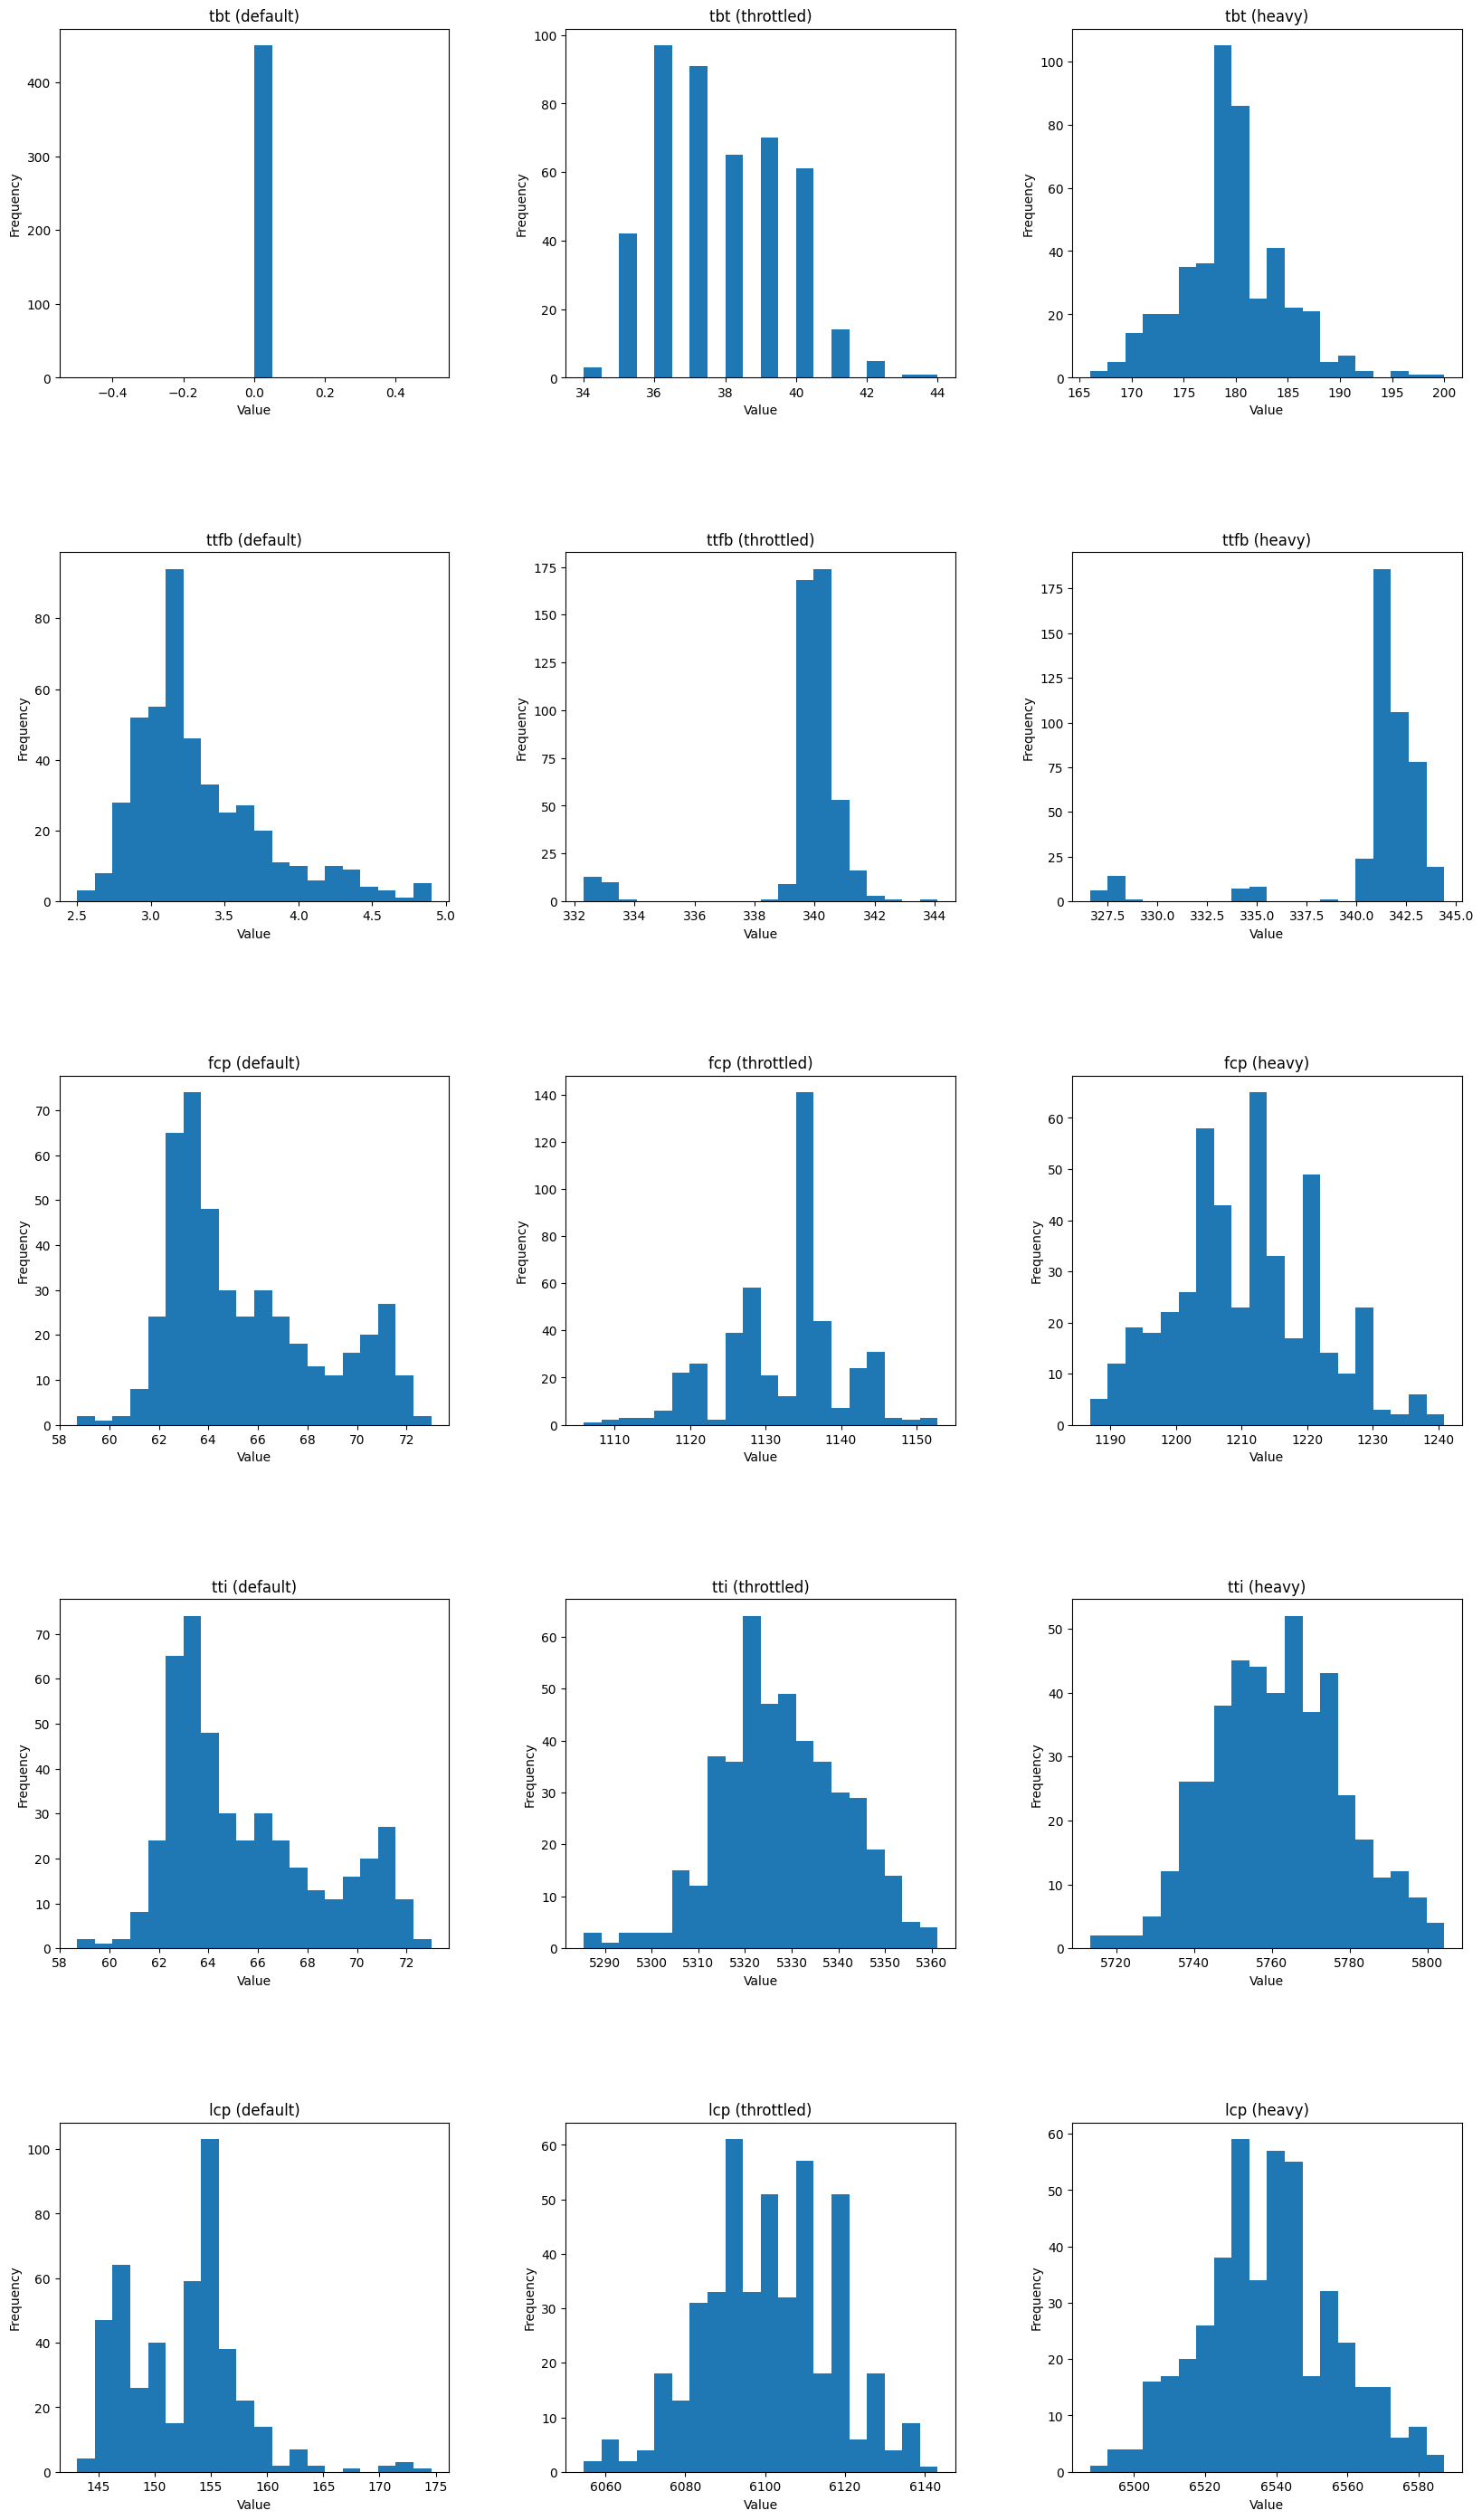

In [139]:
target_features = ['tbt', 'ttfb', 'fcp', 'tti', 'lcp']

fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.95, bottom=0.05)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        axes[y, x].hist(dfs[d][f], bins=20)
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_xlabel('Value')
        axes[y, x].set_ylabel('Frequency')

plt.show()

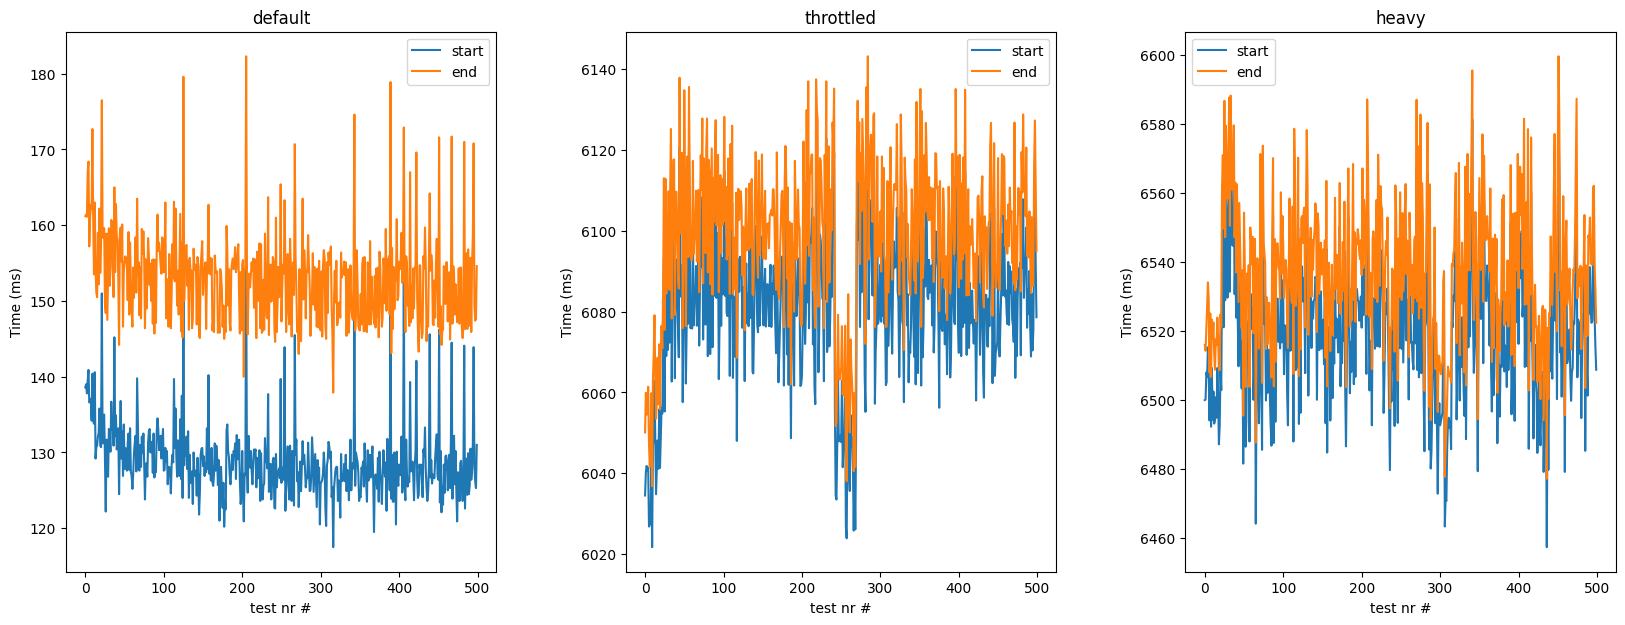

In [140]:
det_df = pd.read_csv(f'{path}details/2024-12-16T16:36:07.040Z_details-csr-sd.csv', sep=',')
det_df_t = pd.read_csv(f'{path}details/2024-12-16T18:34:29.957Z_details-csr-sd-throttled.csv', sep=',')
det_df_ht = pd.read_csv(f'{path}details/2024-12-16T21:24:01.215Z_details-csr-sd-throttled-heavy.csv', sep=',')

lcp_dfs = {
  'default': det_df[(det_df['type'] == 'LCP') & (det_df['idx'] > 5)].reset_index(drop=True),
  'throttled': det_df_t[(det_df_t['type'] == 'LCP') & (det_df_t['idx'] > 5)].reset_index(drop=True),
  'heavy': det_df_ht[(det_df_ht['type'] == 'LCP') & (det_df_ht['idx'] > 5)].reset_index(drop=True),
}
lcp_features = ['start','end','duration','name','element','url','id']


def plot_lcp_line(_df, loc, idx):
  for f in ['start', 'end']:
    loc.plot(_df[f], label=f)
  
  loc.set_title("LCP")
  loc.set_ylabel('Time (ms)')
  loc.set_xlabel('test nr #')
  loc.legend()

graph_row(plot_lcp_line, lcp_dfs, height=6)
plt.show()